In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from pathlib import Path
import numpy as np
import multiprocessing
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# check if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Model

In [3]:
v = 2     # model version
in_c = 2  # number of input channels
num_c = 1 # number of classes to predict

In [4]:
# The optical flow input will look like this
# of = torch.randn(1,2,640,480)

In [5]:
model = EfficientNet.from_pretrained(f'efficientnet-b{v}', in_channels=in_c, num_classes=num_c)
model.to(device);

Loaded pretrained weights for efficientnet-b2


#### The output of the model will look like this

In [6]:
# of = of.to(device)
# model(of).item()

## Data

In [7]:
# directory with the optical flow images
of_dir = '../opical-flow-estimation-with-RAFT/output'
# of_dir = 'npy'
# labels as txt file
labels_f = 'train.txt'

In [8]:
class OFDataset(Dataset):
    def __init__(self, of_dir, label_f):
        self.len = len(list(Path(of_dir).glob('*.npy')))
        self.of_dir = of_dir
        self.label_file = open(label_f).readlines()
    def __len__(self): return self.len
    def __getitem__(self, idx):
        of_array = np.load(Path(self.of_dir)/f'{idx}.npy')
        of_tensor = torch.squeeze(torch.Tensor(of_array))
        label = float(self.label_file[idx].split()[0])
        return [of_tensor, label]

In [9]:
ds = OFDataset(of_dir, labels_f)

In [10]:
# 80% of data for training
# 20% of data for validation
train_split = .8

In [11]:
ds_size = len(ds)
indices = list(range(ds_size))
split = int(np.floor(train_split * ds_size))
train_idx, val_idx = indices[:split], indices[split:]

In [12]:
sample = ds[3]
assert type(sample[0]) == torch.Tensor
assert type(sample[1]) == float

In [13]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [14]:
cpu_cores = multiprocessing.cpu_count()
cpu_cores

8

In [15]:
batch_size=10
train_dl = DataLoader(ds, batch_size=batch_size, sampler=train_sampler, num_workers=0)
val_dl = DataLoader(ds, batch_size=batch_size, sampler=val_sampler, num_workers=0)

In [16]:
def plot(train_loss,val_loss,title):
    N = len(train_loss)
    plt.plot(range(N),train_loss,label = 'train_loss')
    plt.plot(range(N),val_loss, label = 'val_loss')
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.legend()
    plt.savefig("./loss/result_b2.png")
    plt.show()

## Train

In [17]:
epochs = 32
log_train_steps = 100

In [18]:
criterion = nn.MSELoss()
opt = optim.Adam(model.parameters())

In [19]:
history_train_loss = []
history_val_loss = []
best_loss = math.inf
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_losses = []
    for i, sample in enumerate(tqdm(train_dl)):
        of_tensor = sample[0].cuda()
        label = sample[1].float().cuda()
        opt.zero_grad()
        pred = torch.squeeze(model(of_tensor))
        loss = criterion(pred, label)
        train_losses.append(loss)
        loss.backward()
        opt.step()
    mean_train_loss = sum(train_losses)/len(train_losses)
    history_train_loss.append(mean_train_loss)
    print(f'{epoch}t: {mean_train_loss}')
    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for j, val_sample in enumerate(tqdm(val_dl)):
            of_tensor = val_sample[0].cuda()
            label = val_sample[1].float().cuda()
            pred = torch.squeeze(model(of_tensor))
            loss = criterion(pred, label)
            val_losses.append(loss)
        mean_val_loss = sum(val_losses)/len(val_losses)
        torch.save(model.state_dict(), 'model/b2/'+str(epoch)+'.pth')
        if(mean_val_loss < best_loss):
            torch.save(model.state_dict(), 'model/b2/best.pth')
            best_loss = mean_val_loss
        history_val_loss.append(mean_val_loss)
        print(f'{epoch}: {mean_val_loss}')

100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [07:56<00:00,  3.42it/s]


0t: 12.327073097229004


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:30<00:00, 13.28it/s]


0: 7.6606340408325195


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:38<00:00,  3.15it/s]


1t: 3.5225884914398193


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:32<00:00, 12.67it/s]


1: 1.791952133178711


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:50<00:00,  3.08it/s]


2t: 2.382097005844116


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:32<00:00, 12.40it/s]


2: 1.8011126518249512


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:54<00:00,  3.05it/s]


3t: 1.9983218908309937


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:33<00:00, 12.28it/s]


3: 3.4890785217285156


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:55<00:00,  3.05it/s]


4t: 2.1720099449157715


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:32<00:00, 12.47it/s]


4: 2.6067299842834473


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:55<00:00,  3.05it/s]


5t: 1.1478958129882812


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:32<00:00, 12.38it/s]


5: 2.5872654914855957


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:55<00:00,  3.05it/s]


6t: 1.757814645767212


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:33<00:00, 12.22it/s]


6: 2.417956590652466


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:56<00:00,  3.04it/s]


7t: 0.9897319674491882


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:33<00:00, 12.19it/s]


7: 1.9555259943008423


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:57<00:00,  3.03it/s]


8t: 1.0811928510665894


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:33<00:00, 12.19it/s]


8: 2.2848198413848877


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:59<00:00,  3.02it/s]


9t: 0.9699060916900635


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:33<00:00, 12.18it/s]


9: 4.684065341949463


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:02<00:00,  3.01it/s]


10t: 0.8886336088180542


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:34<00:00, 11.96it/s]


10: 2.489178419113159


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:00<00:00,  3.02it/s]


11t: 0.8537626266479492


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:33<00:00, 12.06it/s]


11: 2.530982255935669


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:03<00:00,  3.00it/s]


12t: 0.6193853616714478


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:34<00:00, 11.95it/s]


12: 3.6393051147460938


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:10<00:00,  2.96it/s]


13t: 0.5689553618431091


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [01:56<00:00,  3.49it/s]


13: 1.812453031539917


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:09<00:00,  2.97it/s]


14t: 0.826617419719696


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:30<00:00, 13.21it/s]


14: 2.7633581161499023


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:24<00:00,  2.89it/s]


15t: 0.40562817454338074


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:35<00:00, 11.49it/s]


15: 4.018469333648682


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:21<00:00,  2.91it/s]


16t: 0.6927096843719482


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:35<00:00, 11.57it/s]


16: 3.8410489559173584


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:22<00:00,  2.90it/s]


17t: 0.8808555006980896


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:35<00:00, 11.60it/s]


17: 2.613978147506714


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:22<00:00,  2.90it/s]


18t: 0.4156798720359802


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:35<00:00, 11.57it/s]


18: 3.2977616786956787


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:23<00:00,  2.90it/s]


19t: 0.34053194522857666


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:35<00:00, 11.47it/s]


19: 3.5073201656341553


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:22<00:00,  2.90it/s]


20t: 0.7020350098609924


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:35<00:00, 11.63it/s]


20: 2.3604049682617188


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [09:23<00:00,  2.90it/s]


21t: 0.43554213643074036


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:35<00:00, 11.59it/s]


21: 2.827772855758667


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:49<00:00,  3.08it/s]


22t: 0.3118341863155365


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:31<00:00, 13.02it/s]


22: 2.84157657623291


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:34<00:00,  3.17it/s]


23t: 0.6640544533729553


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:31<00:00, 13.07it/s]


23: 3.086411714553833


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:33<00:00,  3.18it/s]


24t: 0.33046141266822815


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:31<00:00, 13.07it/s]


24: 3.937969923019409


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:32<00:00,  3.18it/s]


25t: 0.27310630679130554


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:31<00:00, 13.06it/s]


25: 4.5009026527404785


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:32<00:00,  3.18it/s]


26t: 0.5566018223762512


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:31<00:00, 13.10it/s]


26: 2.3919625282287598


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:31<00:00,  3.19it/s]


27t: 0.41183754801750183


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:31<00:00, 13.11it/s]


27: 3.896702289581299


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:31<00:00,  3.19it/s]


28t: 0.2546619176864624


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:31<00:00, 13.13it/s]


28: 3.0511343479156494


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:29<00:00,  3.20it/s]


29t: 0.4360639750957489


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:31<00:00, 13.16it/s]


29: 3.847989320755005


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:28<00:00,  3.21it/s]


30t: 0.44935500621795654


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:30<00:00, 13.17it/s]


30: 4.542388439178467


100%|██████████████████████████████████████████████████████████████████████████████| 1632/1632 [08:29<00:00,  3.20it/s]


31t: 0.41834962368011475


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:30<00:00, 13.17it/s]


31: 4.368497371673584


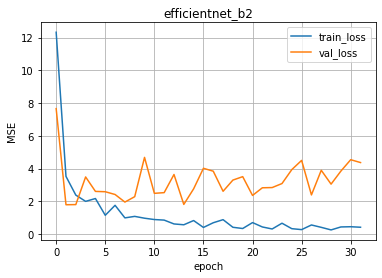

In [20]:
plot(history_train_loss,history_val_loss,"efficientnet_b2")

In [21]:
min(history_val_loss)

tensor(1.7920, device='cuda:0')

In [22]:
import numpy as np
t_loss = np.array([l.cpu().detach().numpy() for l in history_train_loss])
v_loss = np.array([l.cpu().detach().numpy() for l in history_val_loss])

np.save('model/b1/history_train_loss.npy', t_loss)
np.save('model/b1/history_val_loss.npy', v_loss)

In [23]:
t_loss

array([12.327073  ,  3.5225885 ,  2.382097  ,  1.9983219 ,  2.17201   ,
        1.1478958 ,  1.7578146 ,  0.98973197,  1.0811929 ,  0.9699061 ,
        0.8886336 ,  0.8537626 ,  0.61938536,  0.56895536,  0.8266174 ,
        0.40562817,  0.6927097 ,  0.8808555 ,  0.41567987,  0.34053195,
        0.702035  ,  0.43554214,  0.3118342 ,  0.66405445,  0.3304614 ,
        0.2731063 ,  0.5566018 ,  0.41183755,  0.25466192,  0.43606398,
        0.449355  ,  0.41834962], dtype=float32)